In [1]:
import pandas as pd
import numpy as np
import glob

import os

from sklearn.metrics import cohen_kappa_score, confusion_matrix

from scipy.stats import spearmanr, kendalltau, pearsonr

import re

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
ANNOTATIONS_FOLDER="../trabalho_final/anotações_humanas"

### Mapping 4-score to 3-score evaluations to match GPT-4 3-score evaluations

In [4]:
score_mapper = {
    0:0,
    1:0,
    2:1,
    3:2
}

### Original 4-score to 3-score evaluations mapping

This mapping changes the original 4-score 1 evaluation meaning, indicating it **partially answers to the question**, while the original (TREC-DL 21) meaning is the passage **does not answer to the question**.

In [5]:
score_mapper_original = {
    0:0,
    1:1,
    2:1,
    3:2
}

### Mapping 4-score to 2-score evenly

In [6]:
score_mapper_for_2 = {
    0:0,
    1:0,
    2:1,
    3:1    
}

### Alternative version for mapping 4-score to 2-score

In [7]:
score_mapper_for_2_alt = {
    0:0,
    1:1,
    2:1,
    3:1    
}

### Mapping 3-score to 2-score

In [8]:
score_mapper_3_for_2 = {
    0:0,
    1:1,
    2:1    
}

In [9]:
def check_agreement_per_questions(evaluation_a, evaluation_b, correlation_fn, metric_label=None, score='score', fillna=None):
    
    merged_df = evaluation_a.merge(evaluation_b, left_on='doccano_id', right_on='doccano_id')[['query_x', 'passage_x', 'passage_id_x', score + '_x', score + '_y']]
    
    correlations = []
    
    for group_name, group_df in merged_df.groupby('query_x', sort=False):
        correlations.append({'query': group_name,
                             metric_label: globals()[correlation_fn](group_df[score + '_x'], group_df[score + '_y'])[0]})
    
    if fillna is not None:
        correlations_df = pd.DataFrame(correlations).fillna(fillna)
    else:
        correlations_df = pd.DataFrame(correlations)
    
    
    return merged_df, correlations_df

In [10]:
def plot_correlation_data_consolidated(correlation_df, columns_to_plot, plot_title):
    
    fig = plt.figure(figsize=[10, 10])

    fig.suptitle(plot_title, y=0.91)

    plt.grid()

    all_boxplots = plt.boxplot(correlation_df[columns_to_plot], patch_artist=True, vert=False, meanline=True, showmeans=True)

    colors = ['pink', 'lightblue', 'lightgreen']
    
    all_boxes = all_boxplots['boxes']
    
    print(all_boxes)
    
    for i, which_box in enumerate(all_boxes):
        which_box.set_facecolor(colors[i // 3])
    
    
    plt.yticks(range(1, len(columns_to_plot) + 1), columns_to_plot)
    plt.xticks(np.arange(-0.3, 1.0, 0.1))
    
    plt.legend(handles=all_boxes[::3], labels=["Humanos x Humanos", "Humanos x GPT3.5", "Humanos x GPT4"], bbox_to_anchor=(1.0, 1.0))

    plt.show()

In [11]:
def plot_correlation_data(correlation_df, columns_to_plot, plot_title):
    
    fig = plt.figure(figsize=[15, 40])

    fig.suptitle(plot_title, y=0.91)

    plt.grid()

    all_boxplots = plt.boxplot(correlation_df[columns_to_plot].to_numpy().transpose(), patch_artist=True, vert=False, meanline=True, showmeans=True)

    colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow'][::-1]
    
    all_boxes = all_boxplots['boxes']
    
#     print(all_boxes)
    
    for i, which_box in enumerate(all_boxes):
        which_box.set_facecolor(colors[i % 4])

        
    
    plt.yticks(range(4, correlation_df.shape[0] + 1, 4), correlation_df.iloc[::4]['query'])
    plt.xticks(np.arange(-0.3, 1.0, 0.1))

    plt.show()

## Read human annotators evaluations and map the original 4-score values

In [12]:
a1_df = pd.read_csv(os.path.join(ANNOTATIONS_FOLDER, "admin_240_annotations_with_questions.tsv"), sep='\t')
a2_df = pd.read_csv(os.path.join(ANNOTATIONS_FOLDER, "Eduardo_240_annotations_with_questions.tsv"), sep='\t')
a3_df = pd.read_csv(os.path.join(ANNOTATIONS_FOLDER, "Leodecio_240_annotations_with_questions.tsv"), sep='\t')

In [13]:
a1_df['score'].unique()

array([3, 0, 2, 1])

### Compute single score based on the human annotators

In [14]:
all_scores_df = pd.DataFrame()

In [15]:
all_scores_df['a1'] = a1_df['score']
all_scores_df['a2'] = a2_df['score']
all_scores_df['a3'] = a3_df['score']

In [16]:
all_scores_df

,a1,a2,a3
0,3,3,3
1,0,0,0
2,2,1,1
3,2,0,0
4,3,2,1
...,...,...,...
235,2,2,1
236,3,0,1
237,1,3,3
238,1,0,0


In [17]:
single_score = []

for i, row in all_scores_df.iterrows():
    if (row['a1'] == row['a2']) or (row['a1'] == row['a3']):
        single_score.append(row['a1'])

    elif row['a2'] == row['a3']:
        single_score.append(row['a2'])
        
    else:
        single_score.append(np.random.choice([row['a1'], row['a2'], row['a3']], 1)[0])
            
single_score = np.array(single_score)

In [18]:
single_score

array([3, 0, 1, 0, 2, 0, 2, 0, 1, 0, 3, 3, 2, 2, 1, 1, 1, 0, 1, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 2, 0, 1, 2, 2, 0, 1, 0, 3, 2, 3, 3,
       0, 2, 0, 0, 0, 0, 3, 2, 3, 1, 2, 3, 1, 1, 2, 2, 2, 1, 3, 3, 3, 3,
       2, 3, 1, 3, 3, 3, 2, 3, 2, 2, 1, 3, 2, 2, 0, 0, 2, 2, 3, 0, 3, 1,
       1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 3, 3, 2, 3, 2,
       0, 1, 1, 1, 2, 0, 0, 2, 1, 2, 3, 3, 3, 3, 3, 2, 3, 2, 1, 2, 1, 2,
       3, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 3, 1, 2, 0, 1, 1, 3, 3, 1, 1,
       2, 0, 3, 0, 1, 0, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2, 3, 2, 2, 2, 2, 1,
       1, 1, 0, 2, 3, 0, 0, 1, 0, 0, 0, 1, 0, 3, 1, 2, 2, 2, 2, 1, 0, 1,
       2, 1, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0, 2, 3, 3, 2, 3, 2, 1, 3, 1, 3,
       3, 3, 1, 2, 2, 3, 3, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 3, 0, 0])

In [19]:
single_score_df = pd.DataFrame(single_score, columns=['score'])

In [20]:
single_score_df

,score
0,3
1,0
2,1
3,0
4,2
...,...
235,2
236,0
237,3
238,0


### Convert the 4-score to other ranges

In [21]:
a1_df['03_score'] = a1_df['score'].map(score_mapper)
a2_df['03_score'] = a2_df['score'].map(score_mapper)
a3_df['03_score'] = a3_df['score'].map(score_mapper)

single_score_df['03_score'] = single_score_df['score'].map(score_mapper)

In [22]:
a1_df['02_score'] = a1_df['score'].map(score_mapper_for_2)
a2_df['02_score'] = a2_df['score'].map(score_mapper_for_2)
a3_df['02_score'] = a3_df['score'].map(score_mapper_for_2)

single_score_df['02_score'] = single_score_df['score'].map(score_mapper_for_2)

In [23]:
a1_df['02_score_alt'] = a1_df['score'].map(score_mapper_for_2_alt)
a2_df['02_score_alt'] = a2_df['score'].map(score_mapper_for_2_alt)
a3_df['02_score_alt'] = a3_df['score'].map(score_mapper_for_2_alt)

single_score_df['02_score_alt'] = single_score_df['score'].map(score_mapper_for_2_alt)

In [24]:
def cohen_kappa_wrapper(first_series, second_series):
    return (cohen_kappa_score(first_series, second_series), )

## Functions for correlation for 1st, 2nd and all questions

In [25]:
def correlations_1st_set(evaluation_df, which_score, correlation_fn):

    general_agreement_df = pd.DataFrame()

    general_agreement_df['comparisson'] = ['a1', 'a2', 'a3']

    general_agreement_df['a1'] = [np.nan, 
                                  globals()[correlation_fn](a1_df.iloc[0:120][which_score], a2_df.iloc[0:120][which_score])[0], 
                                  globals()[correlation_fn](a1_df.iloc[0:120][which_score], a3_df.iloc[0:120][which_score])[0]]

    general_agreement_df['a2'] = [globals()[correlation_fn](a1_df.iloc[0:120][which_score], a2_df.iloc[0:120][which_score])[0], 
                                  np.nan, 
                                  globals()[correlation_fn](a2_df.iloc[0:120][which_score], a3_df.iloc[0:120][which_score])[0]]

    general_agreement_df['a3'] = [globals()[correlation_fn](a1_df.iloc[0:120][which_score], a3_df.iloc[0:120][which_score])[0], 
                                  globals()[correlation_fn](a2_df.iloc[0:120][which_score], a3_df.iloc[0:120][which_score])[0], 
                                  np.nan]

    general_agreement_df['GPT4 1st 4-score'] = [globals()[correlation_fn](a1_df.iloc[0:120][which_score], evaluation_df[which_score])[0], 
                                                globals()[correlation_fn](a2_df.iloc[0:120][which_score], evaluation_df[which_score])[0], 
                                                globals()[correlation_fn](a3_df.iloc[0:120][which_score], evaluation_df[which_score])[0]]

    general_agreement_df = pd.concat([general_agreement_df, 
                                      pd.DataFrame(data=[['mean'] + general_agreement_df.iloc[:, 1:].mean().to_list()], columns=general_agreement_df.columns)])

    general_agreement_df = pd.concat([general_agreement_df, 
                                      pd.DataFrame(data=[['std'] + general_agreement_df.iloc[:, 1:].std().to_list()], columns=general_agreement_df.columns)])    
    
    human_mean = general_agreement_df.iloc[-2,1:4].mean()

    print("human_mean={}".format(human_mean))
    
    general_agreement_df = pd.concat([general_agreement_df,
                                      pd.DataFrame(data=[['Difference from mean human annotators'] + (general_agreement_df.iloc[-2, 1:] - human_mean).to_list()], columns=general_agreement_df.columns)])

    return general_agreement_df

In [26]:
def correlations_2nd_set(evaluation_df, which_score, correlation_fn):
    
    general_agreement_df = pd.DataFrame()

    general_agreement_df['comparisson'] = ['a1', 'a2', 'a3']

    general_agreement_df['a1'] = [np.nan, 
                                  globals()[correlation_fn](a1_df.iloc[120:240][which_score], a2_df.iloc[120:240][which_score])[0], 
                                  globals()[correlation_fn](a1_df.iloc[120:240][which_score], a3_df.iloc[120:240][which_score])[0]]

    general_agreement_df['a2'] = [globals()[correlation_fn](a1_df.iloc[120:240][which_score], a2_df.iloc[120:240][which_score])[0], 
                                  np.nan, 
                                  globals()[correlation_fn](a2_df.iloc[120:240][which_score], a3_df.iloc[120:240][which_score])[0]]

    general_agreement_df['a3'] = [globals()[correlation_fn](a1_df.iloc[120:240][which_score], a3_df.iloc[120:240][which_score])[0], 
                                  globals()[correlation_fn](a2_df.iloc[120:240][which_score], a3_df.iloc[120:240][which_score])[0], 
                                  np.nan]

    general_agreement_df['GPT4 2nd 4-score'] = [globals()[correlation_fn](a1_df.iloc[120:240][which_score], evaluation_df[which_score])[0], 
                                                globals()[correlation_fn](a2_df.iloc[120:240][which_score], evaluation_df[which_score])[0], 
                                                globals()[correlation_fn](a3_df.iloc[120:240][which_score], evaluation_df[which_score])[0]]

    general_agreement_df = pd.concat([general_agreement_df, 
                                      pd.DataFrame(data=[['mean'] + general_agreement_df.iloc[:, 1:].mean().to_list()], columns=general_agreement_df.columns)])
    
    general_agreement_df = pd.concat([general_agreement_df, 
                                      pd.DataFrame(data=[['std'] + general_agreement_df.iloc[:, 1:].std().to_list()], columns=general_agreement_df.columns)])
    
    human_mean = general_agreement_df.iloc[-2,1:4].mean()

    general_agreement_df = pd.concat([general_agreement_df,
                                      pd.DataFrame(data=[['Difference from mean human annotators'] + (general_agreement_df.iloc[-2, 1:] - human_mean).to_list()], columns=general_agreement_df.columns)])

    return general_agreement_df

In [27]:
def correlations_all(evaluation_df, which_score, correlation_fn):
    
    general_agreement_df = pd.DataFrame()

    general_agreement_df['comparisson'] = ['a1', 'a2', 'a3']

    general_agreement_df['a1'] = [np.nan, 
                                  globals()[correlation_fn](a1_df[which_score], a2_df[which_score])[0], 
                                  globals()[correlation_fn](a1_df[which_score], a3_df[which_score])[0]]

    general_agreement_df['a2'] = [globals()[correlation_fn](a1_df[which_score], a2_df[which_score])[0], 
                                  np.nan, 
                                  globals()[correlation_fn](a2_df[which_score], a3_df[which_score])[0]]

    general_agreement_df['a3'] = [globals()[correlation_fn](a1_df[which_score], a3_df[which_score])[0], 
                                  globals()[correlation_fn](a2_df[which_score], a3_df[which_score])[0], 
                                  np.nan]

    general_agreement_df['GPT4 4-score'] = [globals()[correlation_fn](a1_df[which_score], evaluation_df[which_score])[0], 
                                            globals()[correlation_fn](a2_df[which_score], evaluation_df[which_score])[0], 
                                            globals()[correlation_fn](a3_df[which_score], evaluation_df[which_score])[0]]

    general_agreement_df = pd.concat([general_agreement_df, 
                                      pd.DataFrame(data=[['mean'] + general_agreement_df.iloc[:, 1:].mean().to_list()], columns=general_agreement_df.columns)])

    general_agreement_df = pd.concat([general_agreement_df, 
                                      pd.DataFrame(data=[['std'] + general_agreement_df.iloc[:, 1:].std().to_list()], columns=general_agreement_df.columns)])
    
    
    human_mean = general_agreement_df.iloc[-2,1:4].mean()

    general_agreement_df = pd.concat([general_agreement_df,
                                      pd.DataFrame(data=[['Difference from mean human annotators'] + (general_agreement_df.iloc[-2, 1:] - human_mean).to_list()], columns=general_agreement_df.columns)])
    
    return general_agreement_df

### Functions to compute correlation against single score computed accross human annotators

In [28]:
def correlations_single_score_1st_set(evaluation_df, which_score, correlation_fn):

    general_agreement_df = pd.DataFrame()

    general_agreement_df['comparisson'] = ['single']

    general_agreement_df['a1'] = [globals()[correlation_fn](a1_df.iloc[0:120][which_score], single_score_df.iloc[0:120][which_score])[0]]

    general_agreement_df['a2'] = [globals()[correlation_fn](a2_df.iloc[0:120][which_score], single_score_df.iloc[0:120][which_score])[0]]

    general_agreement_df['a3'] = [globals()[correlation_fn](a3_df.iloc[0:120][which_score], single_score_df.iloc[0:120][which_score])[0]]
    
    human_mean = general_agreement_df.iloc[-1,1:4].mean()
    
    general_agreement_df['human mean'] = human_mean
    
    general_agreement_df['human std'] = general_agreement_df.iloc[-1,1:4].std()

    general_agreement_df['GPT4 1st 4-score'] = [globals()[correlation_fn](single_score_df.iloc[0:120][which_score], evaluation_df[which_score])[0]]

    difference_from_mean = ['Difference from mean human annotators'] + (general_agreement_df.iloc[-1, 1:] - human_mean).to_list()
    difference_from_mean[-2] = np.nan
    
    general_agreement_df = pd.concat([general_agreement_df,
                                      pd.DataFrame(data=[difference_from_mean], columns=general_agreement_df.columns)])

    return general_agreement_df

In [29]:
def correlations_single_score_2nd_set(evaluation_df, which_score, correlation_fn):

    general_agreement_df = pd.DataFrame()

    general_agreement_df['comparisson'] = ['single']

    general_agreement_df['a1'] = [globals()[correlation_fn](a1_df.iloc[120:240][which_score], single_score_df.iloc[120:240][which_score])[0]]

    general_agreement_df['a2'] = [globals()[correlation_fn](a2_df.iloc[120:240][which_score], single_score_df.iloc[120:240][which_score])[0]]

    general_agreement_df['a3'] = [globals()[correlation_fn](a3_df.iloc[120:240][which_score], single_score_df.iloc[120:240][which_score])[0]]
    
    human_mean = general_agreement_df.iloc[-1,1:4].mean()
    
    general_agreement_df['human mean'] = human_mean
    
    general_agreement_df['human std'] = general_agreement_df.iloc[-1,1:4].std()

    general_agreement_df['GPT4 1st 4-score'] = [globals()[correlation_fn](single_score_df.iloc[120:240][which_score], evaluation_df[which_score])[0]]

    difference_from_mean = ['Difference from mean human annotators'] + (general_agreement_df.iloc[-1, 1:] - human_mean).to_list()
    difference_from_mean[-2] = np.nan
    
    general_agreement_df = pd.concat([general_agreement_df,
                                      pd.DataFrame(data=[difference_from_mean], columns=general_agreement_df.columns)])

    return general_agreement_df

In [30]:
def correlations_single_score_all(evaluation_df, which_score, correlation_fn):

    general_agreement_df = pd.DataFrame()

    general_agreement_df['comparisson'] = ['single']

    general_agreement_df['a1'] = [globals()[correlation_fn](a1_df[which_score], single_score_df[which_score])[0]]

    general_agreement_df['a2'] = [globals()[correlation_fn](a2_df[which_score], single_score_df[which_score])[0]]

    general_agreement_df['a3'] = [globals()[correlation_fn](a3_df[which_score], single_score_df[which_score])[0]]
    
    human_mean = general_agreement_df.iloc[-1,1:4].mean()
    
    general_agreement_df['human mean'] = human_mean
    
    general_agreement_df['human std'] = general_agreement_df.iloc[-1,1:4].std()

    general_agreement_df['GPT4 1st 4-score'] = [globals()[correlation_fn](single_score_df[which_score], evaluation_df[which_score])[0]]

    difference_from_mean = ['Difference from mean human annotators'] + (general_agreement_df.iloc[-1, 1:] - human_mean).to_list()
    difference_from_mean[-2] = np.nan
    
    general_agreement_df = pd.concat([general_agreement_df,
                                      pd.DataFrame(data=[difference_from_mean], columns=general_agreement_df.columns)])

    return general_agreement_df

## Check the regenerated evaluations, comparing against the original GPT-4 4-score evaluation

In [31]:
gpt4_1106_1st_df = pd.read_csv(os.path.join("tests", "test_000_119_gpt-4-1106-preview_20231108_fixed_2_scores.tsv"), sep='\t')

In [32]:
gpt4_1106_2nd_df = pd.read_csv(os.path.join("tests", "test_120_239_gpt-4-1106-preview_20231115_fixed_2_scores.tsv"), sep='\t')

In [33]:
gpt4_1106_df = pd.concat([gpt4_1106_1st_df, gpt4_1106_2nd_df], axis=0).reset_index(drop=True)

### Evaluation using the new GPT-4 turbo ― Spearman

In [34]:
correlations_1st_set(gpt4_1106_1st_df, 'score', 'spearmanr')

human_mean=0.7590023888315695


,comparisson,a1,a2,a3,GPT4 1st 4-score
0,a1,NaN,0.7070,0.8171,0.6551
1,a2,0.7070,NaN,0.7529,0.6577
2,a3,0.8171,0.7529,NaN,0.6565
0,mean,0.7620,0.7300,0.7850,0.6564
0,std,0.0551,0.0230,0.0321,0.0011
0,Difference from mean human annotators,0.0030,-0.0290,0.0260,-0.1026


In [35]:
correlations_2nd_set(gpt4_1106_2nd_df, 'score', 'spearmanr')

,comparisson,a1,a2,a3,GPT4 2nd 4-score
0,a1,NaN,0.6639,0.5790,0.5761
1,a2,0.6639,NaN,0.6795,0.6074
2,a3,0.5790,0.6795,NaN,0.6022
0,mean,0.6215,0.6717,0.6293,0.5952
0,std,0.0425,0.0078,0.0503,0.0137
0,Difference from mean human annotators,-0.0194,0.0309,-0.0115,-0.0456


In [36]:
correlations_all(gpt4_1106_df, 'score', 'spearmanr')

,comparisson,a1,a2,a3,GPT4 4-score
0,a1,NaN,0.6931,0.6924,0.6073
1,a2,0.6931,NaN,0.6985,0.6174
2,a3,0.6924,0.6985,NaN,0.6296
0,mean,0.6927,0.6958,0.6954,0.6181
0,std,0.0004,0.0027,0.0031,0.0091
0,Difference from mean human annotators,-0.0019,0.0011,0.0008,-0.0766


### Evaluation using the new GPT-4 turbo ― Cohen Kappa

In [37]:
correlations_1st_set(gpt4_1106_1st_df, 'score', 'cohen_kappa_wrapper')

human_mean=0.5219047399392692


,comparisson,a1,a2,a3,GPT4 1st 4-score
0,a1,NaN,0.4899,0.5755,0.4046
1,a2,0.4899,NaN,0.5003,0.3635
2,a3,0.5755,0.5003,NaN,0.4451
0,mean,0.5327,0.4951,0.5379,0.4044
0,std,0.0428,0.0052,0.0376,0.0333
0,Difference from mean human annotators,0.0108,-0.0268,0.0160,-0.1175


In [38]:
correlations_2nd_set(gpt4_1106_2nd_df, 'score', 'cohen_kappa_wrapper')

,comparisson,a1,a2,a3,GPT4 2nd 4-score
0,a1,NaN,0.3694,0.2866,0.2433
1,a2,0.3694,NaN,0.3227,0.1574
2,a3,0.2866,0.3227,NaN,0.2549
0,mean,0.3280,0.3460,0.3046,0.2185
0,std,0.0414,0.0234,0.0180,0.0435
0,Difference from mean human annotators,0.0018,0.0198,-0.0216,-0.1077


In [39]:
correlations_all(gpt4_1106_df, 'score', 'cohen_kappa_wrapper')

,comparisson,a1,a2,a3,GPT4 4-score
0,a1,NaN,0.4369,0.4294,0.3234
1,a2,0.4369,NaN,0.4105,0.2593
2,a3,0.4294,0.4105,NaN,0.3498
0,mean,0.4331,0.4237,0.4199,0.3108
0,std,0.0037,0.0132,0.0095,0.0380
0,Difference from mean human annotators,0.0076,-0.0019,-0.0057,-0.1147


### Evaluation using the new GPT-4 turbo ― Pearson

In [40]:
correlations_1st_set(gpt4_1106_1st_df, 'score', 'pearsonr')

human_mean=0.7712262020990179


,comparisson,a1,a2,a3,GPT4 1st 4-score
0,a1,NaN,0.7199,0.8251,0.6504
1,a2,0.7199,NaN,0.7688,0.6576
2,a3,0.8251,0.7688,NaN,0.6575
0,mean,0.7725,0.7443,0.7969,0.6552
0,std,0.0526,0.0244,0.0282,0.0034
0,Difference from mean human annotators,0.0012,-0.0269,0.0257,-0.1161


In [41]:
correlations_2nd_set(gpt4_1106_2nd_df, 'score', 'pearsonr')

,comparisson,a1,a2,a3,GPT4 2nd 4-score
0,a1,NaN,0.6575,0.5762,0.5538
1,a2,0.6575,NaN,0.6876,0.5955
2,a3,0.5762,0.6876,NaN,0.6076
0,mean,0.6168,0.6725,0.6319,0.5856
0,std,0.0407,0.0151,0.0557,0.0230
0,Difference from mean human annotators,-0.0236,0.0321,-0.0085,-0.0548


In [42]:
correlations_all(gpt4_1106_df, 'score', 'pearsonr')

,comparisson,a1,a2,a3,GPT4 4-score
0,a1,NaN,0.6982,0.6973,0.5982
1,a2,0.6982,NaN,0.7132,0.6146
2,a3,0.6973,0.7132,NaN,0.6326
0,mean,0.6977,0.7057,0.7052,0.6151
0,std,0.0004,0.0075,0.0079,0.0140
0,Difference from mean human annotators,-0.0051,0.0028,0.0024,-0.0878


### Evaluation using the new GPT-4 turbo ― Kendall Tau

In [43]:
correlations_1st_set(gpt4_1106_1st_df, 'score', 'kendalltau')

human_mean=0.6956243177602369


,comparisson,a1,a2,a3,GPT4 1st 4-score
0,a1,NaN,0.6438,0.7514,0.5824
1,a2,0.6438,NaN,0.6917,0.5849
2,a3,0.7514,0.6917,NaN,0.5817
0,mean,0.6976,0.6677,0.7215,0.5830
0,std,0.0538,0.0239,0.0299,0.0014
0,Difference from mean human annotators,0.0020,-0.0279,0.0259,-0.1126


In [44]:
correlations_2nd_set(gpt4_1106_2nd_df, 'score', 'kendalltau')

,comparisson,a1,a2,a3,GPT4 2nd 4-score
0,a1,NaN,0.5906,0.5106,0.4918
1,a2,0.5906,NaN,0.6002,0.5356
2,a3,0.5106,0.6002,NaN,0.5109
0,mean,0.5506,0.5954,0.5554,0.5128
0,std,0.0400,0.0048,0.0448,0.0179
0,Difference from mean human annotators,-0.0165,0.0283,-0.0117,-0.0544


In [45]:
correlations_all(gpt4_1106_df, 'score', 'kendalltau')

,comparisson,a1,a2,a3,GPT4 4-score
0,a1,NaN,0.6237,0.6224,0.5295
1,a2,0.6237,NaN,0.6263,0.5392
2,a3,0.6224,0.6263,NaN,0.5460
0,mean,0.6231,0.6250,0.6244,0.5382
0,std,0.0006,0.0013,0.0020,0.0068
0,Difference from mean human annotators,-0.0011,0.0009,0.0002,-0.0859


# Check agreement against single score

### Pearson

In [46]:
correlations_single_score_1st_set(gpt4_1106_1st_df, 'score', 'spearmanr')

,comparisson,a1,a2,a3,human mean,human std,GPT4 1st 4-score
0,single,0.8762,0.8323,0.9272,0.8785,0.0475,0.6602
0,Difference from mean human annotators,-0.0024,-0.0462,0.0486,0.0000,NaN,-0.2183


In [47]:
correlations_single_score_2nd_set(gpt4_1106_2nd_df, 'score', 'spearmanr')

,comparisson,a1,a2,a3,human mean,human std,GPT4 1st 4-score
0,single,0.7587,0.8555,0.7666,0.7936,0.0537,0.5574
0,Difference from mean human annotators,-0.0349,0.0619,-0.0270,0.0000,NaN,-0.2361


In [48]:
correlations_single_score_all(gpt4_1106_df, 'score', 'spearmanr')

,comparisson,a1,a2,a3,human mean,human std,GPT4 1st 4-score
0,single,0.8168,0.8421,0.8408,0.8332,0.0142,0.6042
0,Difference from mean human annotators,-0.0164,0.0089,0.0076,0.0000,NaN,-0.2291


### Cohen Kappa

In [49]:
correlations_single_score_1st_set(gpt4_1106_1st_df, 'score', 'cohen_kappa_wrapper')

,comparisson,a1,a2,a3,human mean,human std,GPT4 1st 4-score
0,single,0.7752,0.6917,0.7766,0.7478,0.0486,0.4496
0,Difference from mean human annotators,0.0274,-0.0562,0.0288,0.0000,NaN,-0.2982


In [50]:
correlations_single_score_2nd_set(gpt4_1106_2nd_df, 'score', 'cohen_kappa_wrapper')

,comparisson,a1,a2,a3,human mean,human std,GPT4 1st 4-score
0,single,0.6309,0.6755,0.5799,0.6288,0.0478,0.2275
0,Difference from mean human annotators,0.0022,0.0467,-0.0489,0.0000,NaN,-0.4013


In [51]:
correlations_single_score_all(gpt4_1106_df, 'score', 'cohen_kappa_wrapper')

,comparisson,a1,a2,a3,human mean,human std,GPT4 1st 4-score
0,single,0.7053,0.6866,0.6776,0.6898,0.0141,0.3378
0,Difference from mean human annotators,0.0155,-0.0032,-0.0123,0.0000,NaN,-0.3520


# Check the agreement per question

In [52]:
def correlation_per_question(which_score, a1_df, a2_df, a3_df, gpt4_df, correlation_fn, metric_label, fillna=None):

    all_results = []
    
    res_a1_a2 = check_agreement_per_questions(a1_df, a2_df, correlation_fn=correlation_fn, metric_label=metric_label + "_a1_a2", score=which_score, fillna=fillna)
    res_a1_a3 = check_agreement_per_questions(a1_df, a3_df, correlation_fn=correlation_fn, metric_label=metric_label + "_a1_a3", score=which_score, fillna=fillna)
    res_a2_a3 = check_agreement_per_questions(a2_df, a3_df, correlation_fn=correlation_fn, metric_label=metric_label + "_a2_a3", score=which_score, fillna=fillna)

    res_a1_gpt4 = check_agreement_per_questions(a1_df, gpt4_df, correlation_fn=correlation_fn, metric_label=metric_label + "_a1_gpt4", score=which_score, fillna=fillna)
    res_a2_gpt4 = check_agreement_per_questions(a2_df, gpt4_df, correlation_fn=correlation_fn, metric_label=metric_label + "_a2_gpt4", score=which_score, fillna=fillna)
    res_a3_gpt4 = check_agreement_per_questions(a3_df, gpt4_df, correlation_fn=correlation_fn, metric_label=metric_label + "_a3_gpt4", score=which_score, fillna=fillna)
    
    
    human_combined_res = pd.concat([res_a1_a2[1], res_a1_a3[1].iloc[:, -1], res_a2_a3[1].iloc[:, -1]], axis=1)

    human_combined_res[metric_label + '_human_mean'] = human_combined_res.iloc[:, 1:].mean(axis=1)
    human_combined_res[metric_label + '_human_std'] = human_combined_res.iloc[:, 1:].std(axis=1)
    
    all_results.append(human_combined_res)
    
    human_gpt4_combined_res = pd.concat([res_a1_gpt4[1], res_a2_gpt4[1].iloc[:, -1], res_a3_gpt4[1].iloc[:, -1]], axis=1)
    human_gpt4_combined_res[metric_label + '_gpt4_mean'] = human_gpt4_combined_res.iloc[:, 1:].mean(axis=1)
    human_gpt4_combined_res[metric_label + '_gpt4_std'] = human_gpt4_combined_res.iloc[:, 1:].std(axis=1)

    all_results.append(human_gpt4_combined_res)
    
    all_results_df = pd.concat([human_combined_res, human_gpt4_combined_res.iloc[:, 1:]], axis=1)
    all_results_df['mean difference'] = all_results_df[metric_label + '_human_mean'] - all_results_df[metric_label + '_gpt4_mean']
    
    
    correlations = []
    correlations.append({'annotator': 'human all queries',
                         metric_label: human_combined_res[metric_label + '_human_mean'].mean(),
                         'difference to human mean': 0.0})
    
    correlations.append({'annotator': 'GPT-4 all queries',
                         metric_label: human_gpt4_combined_res[metric_label + '_gpt4_mean'].mean(),
                         'difference to human mean': human_gpt4_combined_res[metric_label + '_gpt4_mean'].mean() - human_combined_res[metric_label + '_human_mean'].mean()})
    
    #
    # Check only non-zero GPT4 means
    #
    
    non_zero = (human_gpt4_combined_res[metric_label + '_gpt4_mean'] != 0.0) & (~np.isnan(human_gpt4_combined_res[metric_label + '_gpt4_mean']))
    
    print(non_zero)
    
    correlations.append({'annotator': 'human non-zero correlation queries',
                         metric_label: human_combined_res.loc[non_zero][metric_label + '_human_mean'].mean(),
                         'difference to human mean': 0.0})
    
    correlations.append({'annotator': 'GPT-4 non-zero correlation queries',
                         metric_label: human_gpt4_combined_res.loc[non_zero][metric_label + '_gpt4_mean'].mean(),
                         'difference to human mean': human_gpt4_combined_res.loc[non_zero][metric_label + '_gpt4_mean'].mean() - human_combined_res.loc[non_zero][metric_label + '_human_mean'].mean()})
    
    
    correlations_df = pd.DataFrame(correlations)
    
    display(correlations_df)
    
    return correlations_df, all_results, all_results_df

### Check for 4-score evaluations

In [53]:
results = correlation_per_question('score', a1_df, a2_df, a3_df, gpt4_1106_df, "cohen_kappa_wrapper", "cohen_kappa")

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7     False
8      True
9      True
10     True
11     True
12    False
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
Name: cohen_kappa_gpt4_mean, dtype: bool


,annotator,cohen_kappa,difference to human mean
0,human all queries,0.3229,0.0000
1,GPT-4 all queries,0.2322,-0.0907
2,human non-zero correlation queries,0.3352,0.0000
3,GPT-4 non-zero correlation queries,0.2533,-0.0819


In [54]:
results[1][0]

,query,cohen_kappa_a1_a2,cohen_kappa_a1_a3,cohen_kappa_a2_a3,cohen_kappa_human_mean,cohen_kappa_human_std
0,Onde está localizada a Praça XV de Novembro?,0.2647,0.3056,0.6970,0.4224,0.1949
1,Qual foi a importância da usina de Volta Redonda RJ para a industrialização brasileira?,-0.0127,0.2647,0.1026,0.1182,0.1138
2,Qual o uso dos códigos SWIFT?,0.6154,0.0000,0.0000,0.2051,0.2901
3,"O que são os celulares ""mid-range""?",0.5082,0.6875,0.2537,0.4831,0.1780
4,Por que os países Guiana e Suriname não são filiados a Conmebol?,0.8361,0.6774,0.8438,0.7857,0.0767
5,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,0.7015,0.5588,0.5455,0.6019,0.0706
6,Qual a maior torcida de futebol do Brasil?,0.8077,0.4231,0.6429,0.6245,0.1576
7,Quando se realizou o plebiscito popular para definir o sistema político do Brasil?,0.0000,0.5082,0.0000,0.1694,0.2396
8,Como transformar uma cidade pacata em um polo turístico?,0.2857,0.4737,0.5833,0.4476,0.1229
9,Quais são os melhores parques nacionais de Portugal?,-0.0811,-0.2500,0.4286,0.0325,0.2884


In [55]:
results[1][1]

,query,cohen_kappa_a1_gpt4,cohen_kappa_a2_gpt4,cohen_kappa_a3_gpt4,cohen_kappa_gpt4_mean,cohen_kappa_gpt4_std
0,Onde está localizada a Praça XV de Novembro?,0.2857,0.2105,0.3056,0.2673,0.0409
1,Qual foi a importância da usina de Volta Redonda RJ para a industrialização brasileira?,0.0909,0.1176,0.1026,0.1037,0.0109
2,Qual o uso dos códigos SWIFT?,1.0000,0.6154,0.0000,0.5385,0.4119
3,"O que são os celulares ""mid-range""?",0.5238,0.2188,0.5082,0.4169,0.1403
4,Por que os países Guiana e Suriname não são filiados a Conmebol?,0.6825,0.6970,0.8438,0.7411,0.0728
5,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,0.0278,0.0141,-0.1842,-0.0474,0.0969
6,Qual a maior torcida de futebol do Brasil?,0.4231,0.6429,1.0000,0.6886,0.2377
7,Quando se realizou o plebiscito popular para definir o sistema político do Brasil?,0.0000,0.0000,0.0000,0.0000,0.0000
8,Como transformar uma cidade pacata em um polo turístico?,0.4030,0.1250,0.2683,0.2654,0.1135
9,Quais são os melhores parques nacionais de Portugal?,-0.4286,0.1304,0.2727,-0.0085,0.3027


In [56]:
results[2]

,query,cohen_kappa_a1_a2,cohen_kappa_a1_a3,cohen_kappa_a2_a3,cohen_kappa_human_mean,cohen_kappa_human_std,cohen_kappa_a1_gpt4,cohen_kappa_a2_gpt4,cohen_kappa_a3_gpt4,cohen_kappa_gpt4_mean,cohen_kappa_gpt4_std,mean difference
0,Onde está localizada a Praça XV de Novembro?,0.2647,0.3056,0.6970,0.4224,0.1949,0.2857,0.2105,0.3056,0.2673,0.0409,0.1551
1,Qual foi a importância da usina de Volta Redonda RJ para a industrialização brasileira?,-0.0127,0.2647,0.1026,0.1182,0.1138,0.0909,0.1176,0.1026,0.1037,0.0109,0.0145
2,Qual o uso dos códigos SWIFT?,0.6154,0.0000,0.0000,0.2051,0.2901,1.0000,0.6154,0.0000,0.5385,0.4119,-0.3333
3,"O que são os celulares ""mid-range""?",0.5082,0.6875,0.2537,0.4831,0.1780,0.5238,0.2188,0.5082,0.4169,0.1403,0.0662
4,Por que os países Guiana e Suriname não são filiados a Conmebol?,0.8361,0.6774,0.8438,0.7857,0.0767,0.6825,0.6970,0.8438,0.7411,0.0728,0.0447
5,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,0.7015,0.5588,0.5455,0.6019,0.0706,0.0278,0.0141,-0.1842,-0.0474,0.0969,0.6494
6,Qual a maior torcida de futebol do Brasil?,0.8077,0.4231,0.6429,0.6245,0.1576,0.4231,0.6429,1.0000,0.6886,0.2377,-0.0641
7,Quando se realizou o plebiscito popular para definir o sistema político do Brasil?,0.0000,0.5082,0.0000,0.1694,0.2396,0.0000,0.0000,0.0000,0.0000,0.0000,0.1694
8,Como transformar uma cidade pacata em um polo turístico?,0.2857,0.4737,0.5833,0.4476,0.1229,0.4030,0.1250,0.2683,0.2654,0.1135,0.1822
9,Quais são os melhores parques nacionais de Portugal?,-0.0811,-0.2500,0.4286,0.0325,0.2884,-0.4286,0.1304,0.2727,-0.0085,0.3027,0.0410


In [57]:
gpt4_1106_df[gpt4_1106_df['query'] == "quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?"]

,doccano_id,query,passage,passage_id,score,reasoning,usage,cost,duration,saved_cost
50,4151,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,"As Sete Maravilhas do Mundo moderno foram eleitas por meio de uma votação informal, idealizada por uma organização da Suíça, baseadas em critérios como beleza, complexidade, valor histórico, relevância cultural e significado arquitetônico. A seleção foi feita mundialmente por votos pela internet e por telefone, contando com mais de 100 milhões de participações, que escolheram entre 200 monumentos de várias partes do mundo. O anúncio dos monumentos escolhidos aconteceu no dia sete de julho de 2007, no Estádio da Luz, em Portugal. Além do Cristo Redentor, os outros monumentos que completam a lista das Sete Maravilhas do Mundo Moderno são: – Coliseu de Roma (Itália) – Chichén Itzá (México) – Machu Picchu (Peru) – Muralha da China (China) As Ruínas de Petra (Jordânia) – Taj Mahal (Índia) Como visitar o Cristo Redentor O Cristo está situado no alto do Morro do Corcovado, no Parque Nacional da Tijuca. O monumento é acessível de van, carro, ou um trem, que realiza um tour pela Mata Atlântica até chegar ao topo do morro. O valor do ingresso varia conforme a temporada e pode ser adquirido no site da Paineiras Corcovado.",clueweb22-pt0001-26-08948_3,3,"A passagem responde diretamente à pergunta, listando os critérios usados para definir as Sete Maravilhas do Mundo Moderno, que são beleza, complexidade, valor histórico, relevância cultural e significado arquitetônico.","{'prompt_tokens': 832, 'completion_tokens': 68, 'total_tokens': 900}",0.0290,2.1026,0.0000
51,4152,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,"7 maravilhas do mundo moderno e antigo [resumo] 7 maravilhas do mundo moderno e antigo As 7 maravilhas do mundo são cosnstruções arquitetônicas que desafiaram civilizações há milhares de anos atrás com sua beleza e grandiosidade. 7 maravilhas do mundo moderno e antigo As 7 maravilhas do mundo são o grande fascínio do planeta Terra. Elas são a representação máxima da capacidade humana em conseguir embelezar ainda mais o planeta. São modelos arquitetônicos e artísticos que caracterizam a sociedade como um todo. Seja a que construiu, seja a que emergiu logo depois. As 7 maravilhas do mundo são a história do passado em meio ao presente a ser contada no futuro. As 7 maravilhas do mundo moderno são uma revisão das maravilhas do mundo antigo. Divididas em duas diferentes classes, a sua real semelhança está na beleza e no significado cultural que cada uma possui. Confira as 7 maravilhas do mundo antigo Primeiramente é preciso dar voz ao passado. As 7 maravilhas do mundo antigo representam, inclusive, monumentos que já não existem mais. Contudo, ainda permanecem presentes em relatos e evidências passadas. 1) As pirâmides do Egito (Imagem: Reprodução)",clueweb22-pt0000-84-11335_0,0,"A passagem não fornece informações sobre os critérios usados para definir os monumentos como maravilhas do mundo moderno, apenas descreve de forma geral o que são as 7 maravilhas e menciona as maravilhas do mundo antigo, sem entrar em detalhes sobre os critérios de seleção.","{'prompt_tokens': 838, 'completion_tokens': 85, 'total_tokens': 923}",0.0302,2.2499,0.0000
52,4153,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,"As 7 maravilhas do mundo: quais são as antigas e as modernas História As 7 maravilhas do mundo: quais são as antigas e as modernas Eles foram consideradas os lugares e monumentos mais bonitos e impactantes já existentes. Conheça as 7 maravilhas do mundo antigo e moderno. Fonte: Pinterest Provavelmente, você já ouviu falar sobre as 7 maravilhas do mundo antigo, não é mesmo? Basicamente, elas se tratam de monumentos e construções erguidas há milhares de anos. Certamente eles mereceram esse titulo pela beleza e eficiência mesmo diante de técnicas tão rudimentares. Mas, como você também de

In [58]:
a2_df[a2_df['query'] == "quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?"]

,doccano_id,query,passage,passage_id,label,score,03_score,02_score,02_score_alt
50,4151,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,"As Sete Maravilhas do Mundo moderno foram eleitas por meio de uma votação informal, idealizada por uma organização da Suíça, baseadas em critérios como beleza, complexidade, valor histórico, relevância cultural e significado arquitetônico. A seleção foi feita mundialmente por votos pela internet e por telefone, contando com mais de 100 milhões de participações, que escolheram entre 200 monumentos de várias partes do mundo. O anúncio dos monumentos escolhidos aconteceu no dia sete de julho de 2007, no Estádio da Luz, em Portugal. Além do Cristo Redentor, os outros monumentos que completam a lista das Sete Maravilhas do Mundo Moderno são: – Coliseu de Roma (Itália) – Chichén Itzá (México) – Machu Picchu (Peru) – Muralha da China (China) As Ruínas de Petra (Jordânia) – Taj Mahal (Índia) Como visitar o Cristo Redentor O Cristo está situado no alto do Morro do Corcovado, no Parque Nacional da Tijuca. O monumento é acessível de van, carro, ou um trem, que realiza um tour pela Mata Atlântica até chegar ao topo do morro. O valor do ingresso varia conforme a temporada e pode ser adquirido no site da Paineiras Corcovado.",clueweb22-pt0001-26-08948_3,Perfect,3,2,1,1
51,4152,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,"7 maravilhas do mundo moderno e antigo [resumo] 7 maravilhas do mundo moderno e antigo As 7 maravilhas do mundo são cosnstruções arquitetônicas que desafiaram civilizações há milhares de anos atrás com sua beleza e grandiosidade. 7 maravilhas do mundo moderno e antigo As 7 maravilhas do mundo são o grande fascínio do planeta Terra. Elas são a representação máxima da capacidade humana em conseguir embelezar ainda mais o planeta. São modelos arquitetônicos e artísticos que caracterizam a sociedade como um todo. Seja a que construiu, seja a que emergiu logo depois. As 7 maravilhas do mundo são a história do passado em meio ao presente a ser contada no futuro. As 7 maravilhas do mundo moderno são uma revisão das maravilhas do mundo antigo. Divididas em duas diferentes classes, a sua real semelhança está na beleza e no significado cultural que cada uma possui. Confira as 7 maravilhas do mundo antigo Primeiramente é preciso dar voz ao passado. As 7 maravilhas do mundo antigo representam, inclusive, monumentos que já não existem mais. Contudo, ainda permanecem presentes em relatos e evidências passadas. 1) As pirâmides do Egito (Imagem: Reprodução)",clueweb22-pt0000-84-11335_0,Highly Relevant,2,1,1,1
52,4153,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,"As 7 maravilhas do mundo: quais são as antigas e as modernas História As 7 maravilhas do mundo: quais são as antigas e as modernas Eles foram consideradas os lugares e monumentos mais bonitos e impactantes já existentes. Conheça as 7 maravilhas do mundo antigo e moderno. Fonte: Pinterest Provavelmente, você já ouviu falar sobre as 7 maravilhas do mundo antigo, não é mesmo? Basicamente, elas se tratam de monumentos e construções erguidas há milhares de anos. Certamente eles mereceram esse titulo pela beleza e eficiência mesmo diante de técnicas tão rudimentares. Mas, como você também deve saber, não é só o mundo antigo que conta com suas maravilhas arquitetônicas. Em 2005, por votação online não oficial, foram eleitas as 7 maravilhas do mundo moderno. Aliás, a votação foi organizada pela organização suíça New Open World Corporation. Fonte: Pinterest Inicialmente, a lista da seleção contava com 200 monumentos inscritos, sendo cada um de uma parte do mundo. No entanto, a votação terminou com os 77 mais votados pelo público. Assim, os primeiros 7 monumentos e construções mais votados, então, ficaram conhecidos a partir de então como as 7 maravilhas do mundo moderno.",clueweb22-pt0001-23-03982_0,Highly Relevant,2,1,1,1
53,4154,

In [59]:
gpt4_1106_df['a2_score'] = a2_df['score']

In [60]:
gpt4_1106_df[gpt4_1106_df['query'] == "quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?"][['score','a2_score']]

,score,a2_score
50,3,3
51,0,2
52,1,2
53,2,1
54,1,2
55,2,3
56,1,1
57,0,1
58,2,2
59,1,2


In [61]:
results[2].columns

Index(['query', 'cohen_kappa_a1_a2', 'cohen_kappa_a1_a3', 'cohen_kappa_a2_a3',
       'cohen_kappa_human_mean', 'cohen_kappa_human_std',
       'cohen_kappa_a1_gpt4', 'cohen_kappa_a2_gpt4', 'cohen_kappa_a3_gpt4',
       'cohen_kappa_gpt4_mean', 'cohen_kappa_gpt4_std', 'mean difference'],
      dtype='object')

In [62]:
results[2]['cohen_kappa_human_mean'].describe()

count   24.0000
mean     0.3229
std      0.1989
min     -0.0236
25%      0.1997
50%      0.2746
75%      0.4452
max      0.7857
Name: cohen_kappa_human_mean, dtype: float64

In [63]:
results[2]['cohen_kappa_gpt4_mean'].describe()

count   24.0000
mean     0.2322
std      0.2313
min     -0.0561
25%      0.0209
50%      0.2208
75%      0.3599
max      0.7411
Name: cohen_kappa_gpt4_mean, dtype: float64

In [95]:
spearmanr(results[2]['cohen_kappa_human_mean'], results[2]['cohen_kappa_gpt4_mean'].to_numpy())

SignificanceResult(statistic=0.5509893585351534, pvalue=0.005263585043630156)

In [97]:
results[2].head()

,query,cohen_kappa_a1_a2,cohen_kappa_a1_a3,cohen_kappa_a2_a3,cohen_kappa_human_mean,cohen_kappa_human_std,cohen_kappa_a1_gpt4,cohen_kappa_a2_gpt4,cohen_kappa_a3_gpt4,cohen_kappa_gpt4_mean,cohen_kappa_gpt4_std,mean difference
0,Onde está localizada a Praça XV de Novembro?,0.2647,0.3056,0.6970,0.4224,0.1949,0.2857,0.2105,0.3056,0.2673,0.0409,0.1551
1,Qual foi a importância da usina de Volta Redonda RJ para a industrialização brasileira?,-0.0127,0.2647,0.1026,0.1182,0.1138,0.0909,0.1176,0.1026,0.1037,0.0109,0.0145
2,Qual o uso dos códigos SWIFT?,0.6154,0.0000,0.0000,0.2051,0.2901,1.0000,0.6154,0.0000,0.5385,0.4119,-0.3333
3,"O que são os celulares ""mid-range""?",0.5082,0.6875,0.2537,0.4831,0.1780,0.5238,0.2188,0.5082,0.4169,0.1403,0.0662
4,Por que os países Guiana e Suriname não são filiados a Conmebol?,0.8361,0.6774,0.8438,0.7857,0.0767,0.6825,0.6970,0.8438,0.7411,0.0728,0.0447


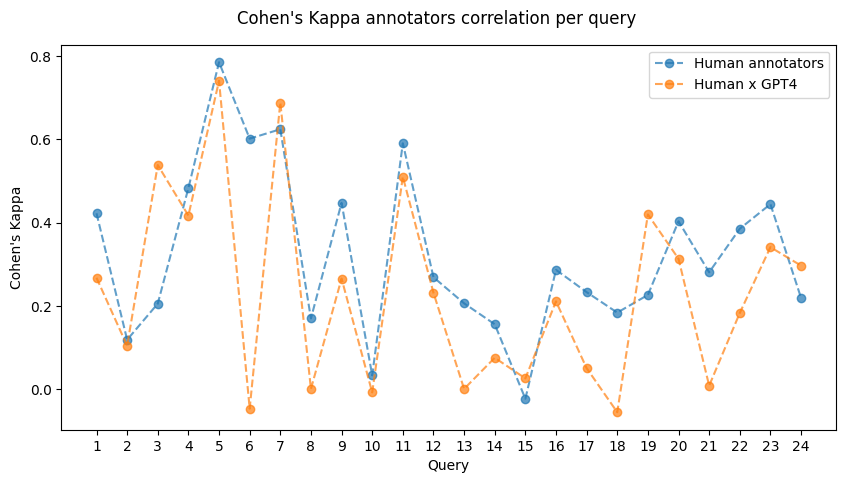

In [119]:
fig = plt.figure(figsize=[10, 5])

# plt.grid()

fig.suptitle("Cohen's Kappa annotators correlation per query", y=0.95)

plt.plot(range(1, 25), results[2]['cohen_kappa_human_mean'], marker='o', linestyle='--', alpha=0.7)
plt.plot(range(1, 25), results[2]['cohen_kappa_gpt4_mean'], marker='o', linestyle='--', alpha=0.7)

plt.xticks(range(1, 25))

plt.legend(labels=["Human annotators", "Human x GPT4"])

plt.xlabel("Query")
plt.ylabel("Cohen's Kappa")

plt.show()

In [64]:
spearmanr_results = correlation_per_question('score', a1_df, a2_df, a3_df, gpt4_1106_df, "spearmanr", "spearman")

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7     False
8      True
9      True
10     True
11     True
12    False
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
Name: spearman_gpt4_mean, dtype: bool


/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445

,annotator,spearman,difference to human mean
0,human all queries,0.6043,0.0000
1,GPT-4 all queries,0.4962,-0.1081
2,human non-zero correlation queries,0.6071,0.0000
3,GPT-4 non-zero correlation queries,0.4962,-0.1109


In [65]:
spearmanr_results[2]

,query,spearman_a1_a2,spearman_a1_a3,spearman_a2_a3,spearman_human_mean,spearman_human_std,spearman_a1_gpt4,spearman_a2_gpt4,spearman_a3_gpt4,spearman_gpt4_mean,spearman_gpt4_std,mean difference
0,Onde está localizada a Praça XV de Novembro?,0.6467,0.7165,0.9716,0.7783,0.1397,0.5929,0.6113,0.6801,0.6281,0.0375,0.1502
1,Qual foi a importância da usina de Volta Redonda RJ para a industrialização brasileira?,0.4583,0.7009,0.5894,0.5829,0.0992,0.4562,0.5306,0.2443,0.4104,0.1213,0.1725
2,Qual o uso dos códigos SWIFT?,0.6667,NaN,NaN,0.6667,0.0000,1.0000,0.6667,NaN,0.8333,0.1667,-0.1667
3,"O que são os celulares ""mid-range""?",0.8729,0.9456,0.8519,0.8901,0.0402,0.4071,0.5710,0.3019,0.4267,0.1107,0.4634
4,Por que os países Guiana e Suriname não são filiados a Conmebol?,0.9638,0.9785,0.9964,0.9796,0.0134,0.9638,1.0000,0.9964,0.9867,0.0163,-0.0072
5,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,0.8435,0.8523,0.8029,0.8329,0.0215,0.5488,0.4761,0.5239,0.5163,0.0302,0.3166
6,Qual a maior torcida de futebol do Brasil?,0.7144,0.4082,0.7500,0.6242,0.1534,0.4082,0.7500,1.0000,0.7194,0.2425,-0.0952
7,Quando se realizou o plebiscito popular para definir o sistema político do Brasil?,NaN,0.6708,NaN,0.6708,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
8,Como transformar uma cidade pacata em um polo turístico?,0.5348,0.9802,0.5923,0.7025,0.1978,0.5658,0.4802,0.6194,0.5551,0.0573,0.1473
9,Quais são os melhores parques nacionais de Portugal?,0.2182,0.1409,0.5738,0.3110,0.1885,-0.5216,-0.3320,-0.0772,-0.3103,0.1821,0.6212


In [66]:
pearsonr_results = correlation_per_question('score', a1_df, a2_df, a3_df, gpt4_1106_df, "pearsonr", "pearson")

/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarni

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7     False
8      True
9      True
10     True
11     True
12    False
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
Name: pearson_gpt4_mean, dtype: bool


/home/eduseiti/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,annotator,pearson,difference to human mean
0,human all queries,0.6194,0.0000
1,GPT-4 all queries,0.4869,-0.1325
2,human non-zero correlation queries,0.6153,0.0000
3,GPT-4 non-zero correlation queries,0.4869,-0.1284


In [67]:
pearsonr_results[2]

,query,pearson_a1_a2,pearson_a1_a3,pearson_a2_a3,pearson_human_mean,pearson_human_std,pearson_a1_gpt4,pearson_a2_gpt4,pearson_a3_gpt4,pearson_gpt4_mean,pearson_gpt4_std,mean difference
0,Onde está localizada a Praça XV de Novembro?,0.5909,0.6524,0.9259,0.7231,0.1456,0.6022,0.5482,0.5864,0.5789,0.0227,0.1442
1,Qual foi a importância da usina de Volta Redonda RJ para a industrialização brasileira?,0.4152,0.7309,0.6191,0.5884,0.1307,0.4495,0.5319,0.2070,0.3961,0.1379,0.1923
2,Qual o uso dos códigos SWIFT?,0.6667,NaN,NaN,0.6667,0.0000,1.0000,0.6667,NaN,0.8333,0.1667,-0.1667
3,"O que são os celulares ""mid-range""?",0.8268,0.8992,0.7351,0.8204,0.0672,0.3525,0.5022,0.1544,0.3364,0.1424,0.4840
4,Por que os países Guiana e Suriname não são filiados a Conmebol?,0.9784,0.9605,0.9749,0.9713,0.0077,0.8940,0.9548,0.9741,0.9410,0.0341,0.0303
5,quais os critérios de definição dos monumentos intitulados maravilhas do mundo moderno?,0.8427,0.8365,0.8018,0.8270,0.0180,0.5752,0.5238,0.5048,0.5346,0.0297,0.2924
6,Qual a maior torcida de futebol do Brasil?,0.6784,0.4900,0.8438,0.6707,0.1445,0.4900,0.8438,1.0000,0.7779,0.2134,-0.1072
7,Quando se realizou o plebiscito popular para definir o sistema político do Brasil?,NaN,0.7534,NaN,0.7534,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
8,Como transformar uma cidade pacata em um polo turístico?,0.5270,0.9682,0.5784,0.6912,0.1970,0.5774,0.4564,0.6211,0.5516,0.0697,0.1396
9,Quais são os melhores parques nacionais de Portugal?,0.2182,0.1216,0.5571,0.2990,0.1867,-0.4880,-0.2485,0.1384,-0.1993,0.2581,0.4983


### Confusion matrices

In [77]:
confusion_matrix_a1_gpt4 = confusion_matrix(a1_df['score'], gpt4_1106_df['score'])

In [78]:
confusion_matrix_a2_gpt4 = confusion_matrix(a2_df['score'], gpt4_1106_df['score'])

In [79]:
confusion_matrix_a3_gpt4 = confusion_matrix(a3_df['score'], gpt4_1106_df['score'])

#### A1 x GPT4 confusion matrix

In [80]:
confusion_matrix_a1_gpt4

array([[25, 13, 12,  2],
       [12, 24, 18, 14],
       [ 4, 11, 23, 27],
       [ 1,  5,  3, 46]])

In [81]:
confusion_matrix_a1_gpt4.sum(axis=1)

array([52, 68, 65, 55])

In [82]:
confusion_matrix_a1_gpt4.sum(axis=0)

array([42, 53, 56, 89])

#### A2 x GPT4 confusion matrix

In [84]:
confusion_matrix_a2_gpt4

array([[29, 17, 11,  2],
       [ 5, 15, 17, 10],
       [ 8, 20, 24, 40],
       [ 0,  1,  4, 37]])

In [85]:
confusion_matrix_a2_gpt4.sum(axis=1)

array([59, 47, 92, 42])

In [86]:
confusion_matrix_a2_gpt4.sum(axis=0)

array([42, 53, 56, 89])

#### A3 x GPT4 confusion matrix

In [87]:
confusion_matrix_a3_gpt4

array([[29, 13, 10,  1],
       [ 7, 21, 11, 13],
       [ 6, 12, 19, 19],
       [ 0,  7, 16, 56]])

In [88]:
confusion_matrix_a3_gpt4.sum(axis=1)

array([53, 52, 56, 79])

In [89]:
confusion_matrix_a3_gpt4.sum(axis=0)

array([42, 53, 56, 89])

In [71]:
a1_1 = a1_df[a1_df['query'] == "Qual o uso dos códigos SWIFT?"][['passage_id', 'score']]

In [72]:
a2_1 = a2_df[a2_df['query'] == "Qual o uso dos códigos SWIFT?"][['passage_id', 'score']]

In [73]:
a3_1 = a3_df[a3_df['query'] == "Qual o uso dos códigos SWIFT?"][['passage_id', 'score']]

In [74]:
a2_1

,passage_id,score
20,clueweb22-pt0000-76-18202_3,3
21,clueweb22-pt0000-96-07045_3,3
22,clueweb22-pt0000-81-05159_0,3
23,clueweb22-pt0001-91-11827_0,3
24,clueweb22-pt0000-33-13712_0,3
25,clueweb22-pt0001-70-16813_0,3
26,clueweb22-pt0001-89-01763_2,2
27,clueweb22-pt0001-81-10821_1,3
28,clueweb22-pt0000-39-05372_0,3
29,clueweb22-pt0000-50-19284_4,2


In [75]:
a1_1

,passage_id,score
20,clueweb22-pt0000-76-18202_3,3
21,clueweb22-pt0000-96-07045_3,3
22,clueweb22-pt0000-81-05159_0,3
23,clueweb22-pt0001-91-11827_0,3
24,clueweb22-pt0000-33-13712_0,3
25,clueweb22-pt0001-70-16813_0,3
26,clueweb22-pt0001-89-01763_2,3
27,clueweb22-pt0001-81-10821_1,3
28,clueweb22-pt0000-39-05372_0,3
29,clueweb22-pt0000-50-19284_4,2


In [76]:
a3_1

,passage_id,score
20,clueweb22-pt0000-76-18202_3,3
21,clueweb22-pt0000-96-07045_3,3
22,clueweb22-pt0000-81-05159_0,3
23,clueweb22-pt0001-91-11827_0,3
24,clueweb22-pt0000-33-13712_0,3
25,clueweb22-pt0001-70-16813_0,3
26,clueweb22-pt0001-89-01763_2,3
27,clueweb22-pt0001-81-10821_1,3
28,clueweb22-pt0000-39-05372_0,3
29,clueweb22-pt0000-50-19284_4,3
